In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"


In [3]:
# get the name of all opsim dbs 
import os
import glob

workpath = os.getcwd()
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [4]:
def scale(arr, mode=0):
    """scale array by max"""
    newarr = arr / arr.max()
    if mode==1:
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [5]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap



In [6]:
def get_df_norm( fomcsv = 'df_tgapsFoM_GP.csv'):
    """return normalized dataframe"""

    df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    df_new = df_fom[ ['db'] ].copy()
    for col in cols_all:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col]) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new

In [7]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']



### time gaps galactic plane

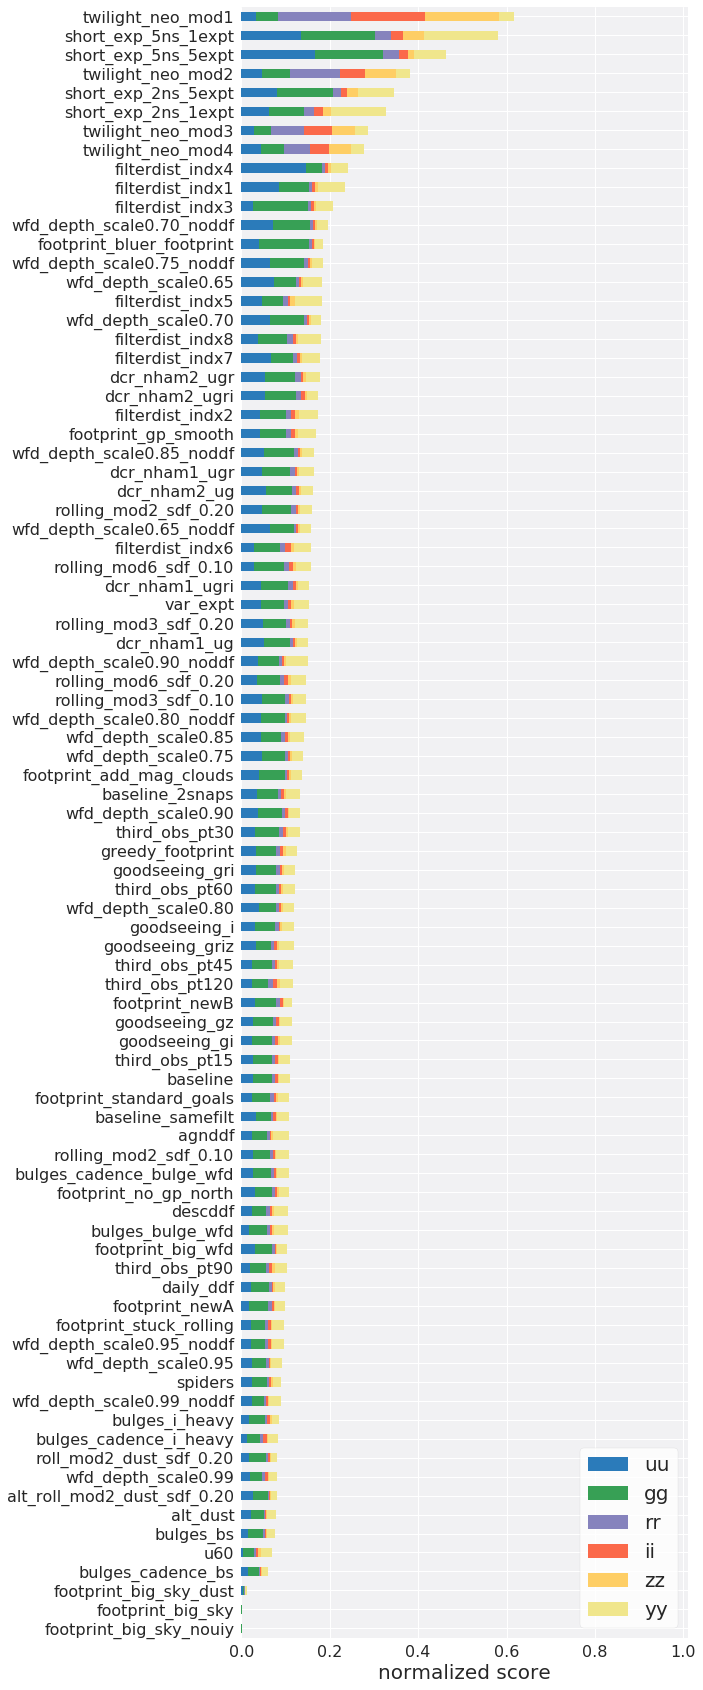

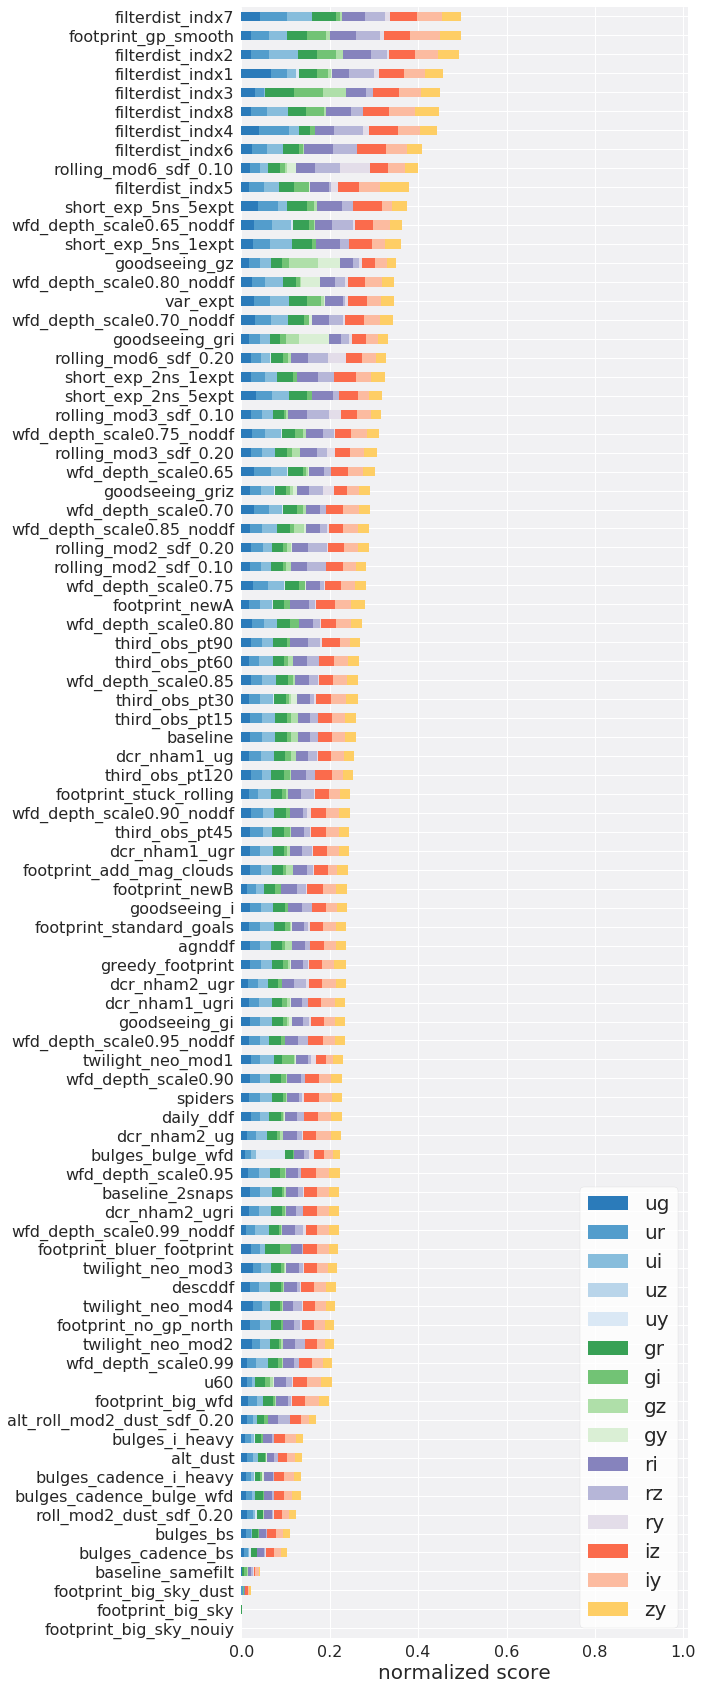

In [9]:
fomcsv = './data/df_tgapsFoM_GP.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_tgapsGP_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_tgapsGP_diff.pdf', cmap=get_mycmap(pairs='diff') )



### time gaps LMC

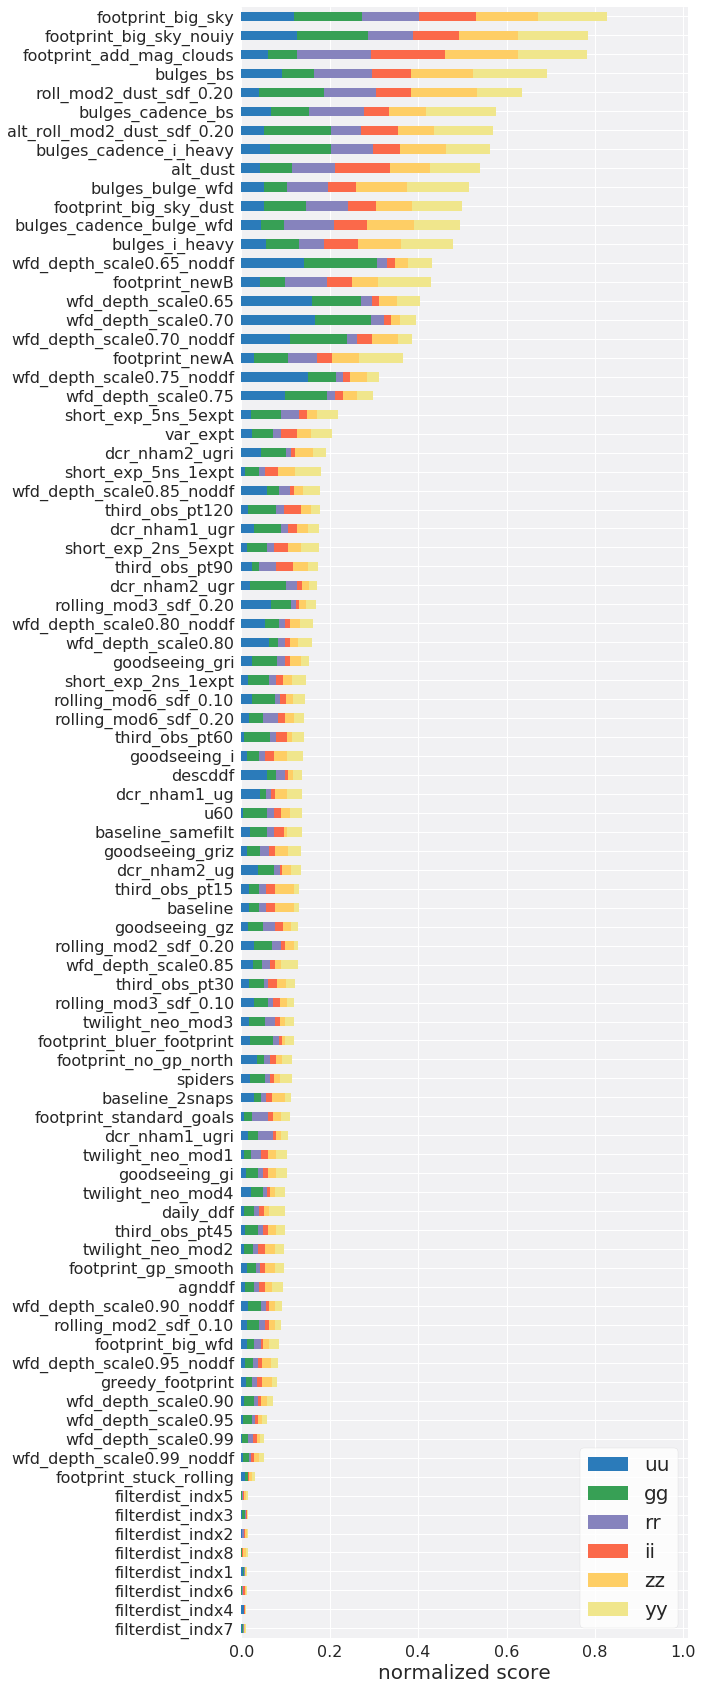

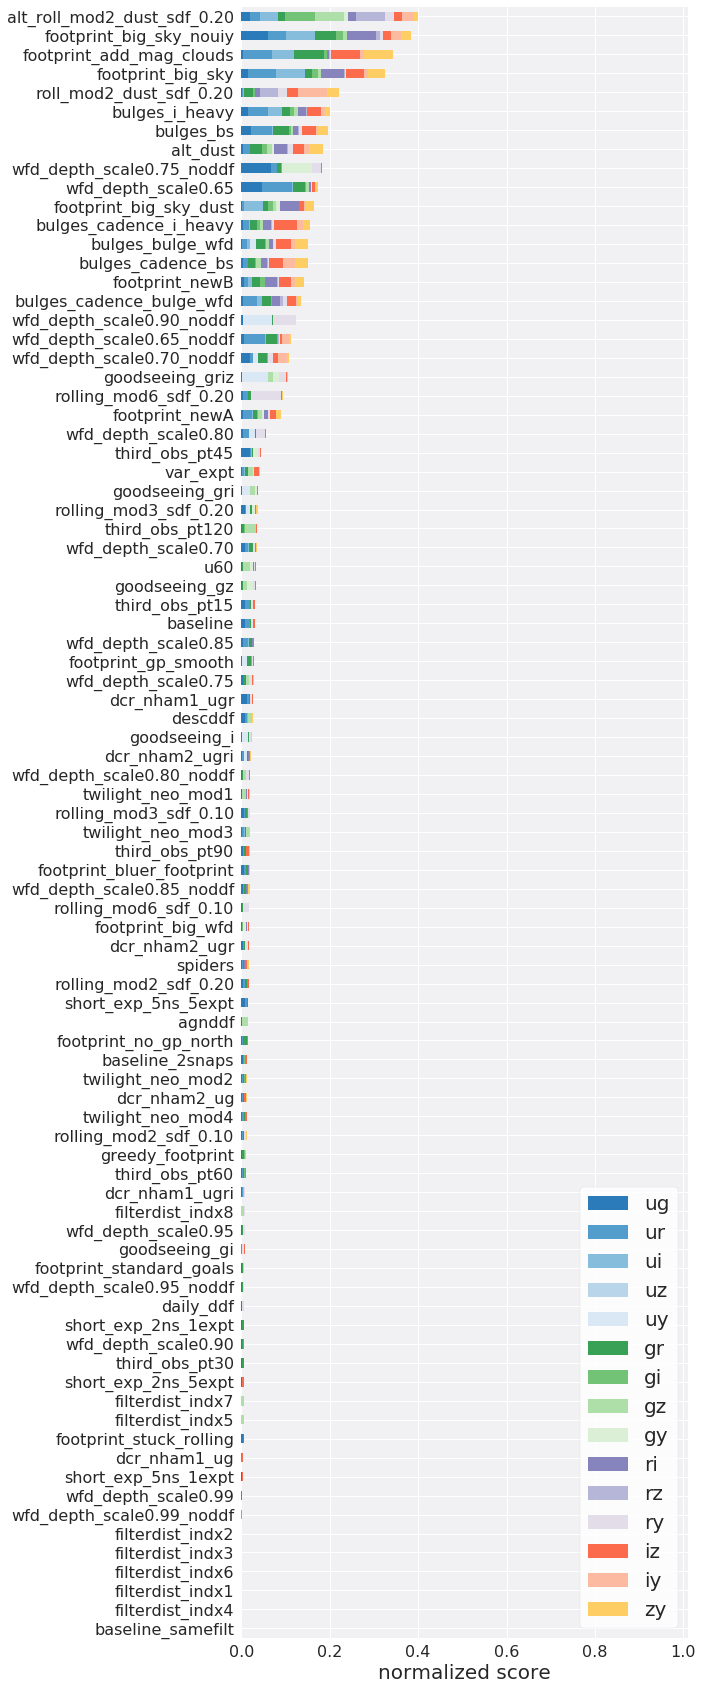

In [11]:
fomcsv = 'data/df_tgapsFoM_LMC.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_tgapsLMC_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_tgapsLMC_diff.pdf', cmap=get_mycmap(pairs='diff') )


### time gaps SMC

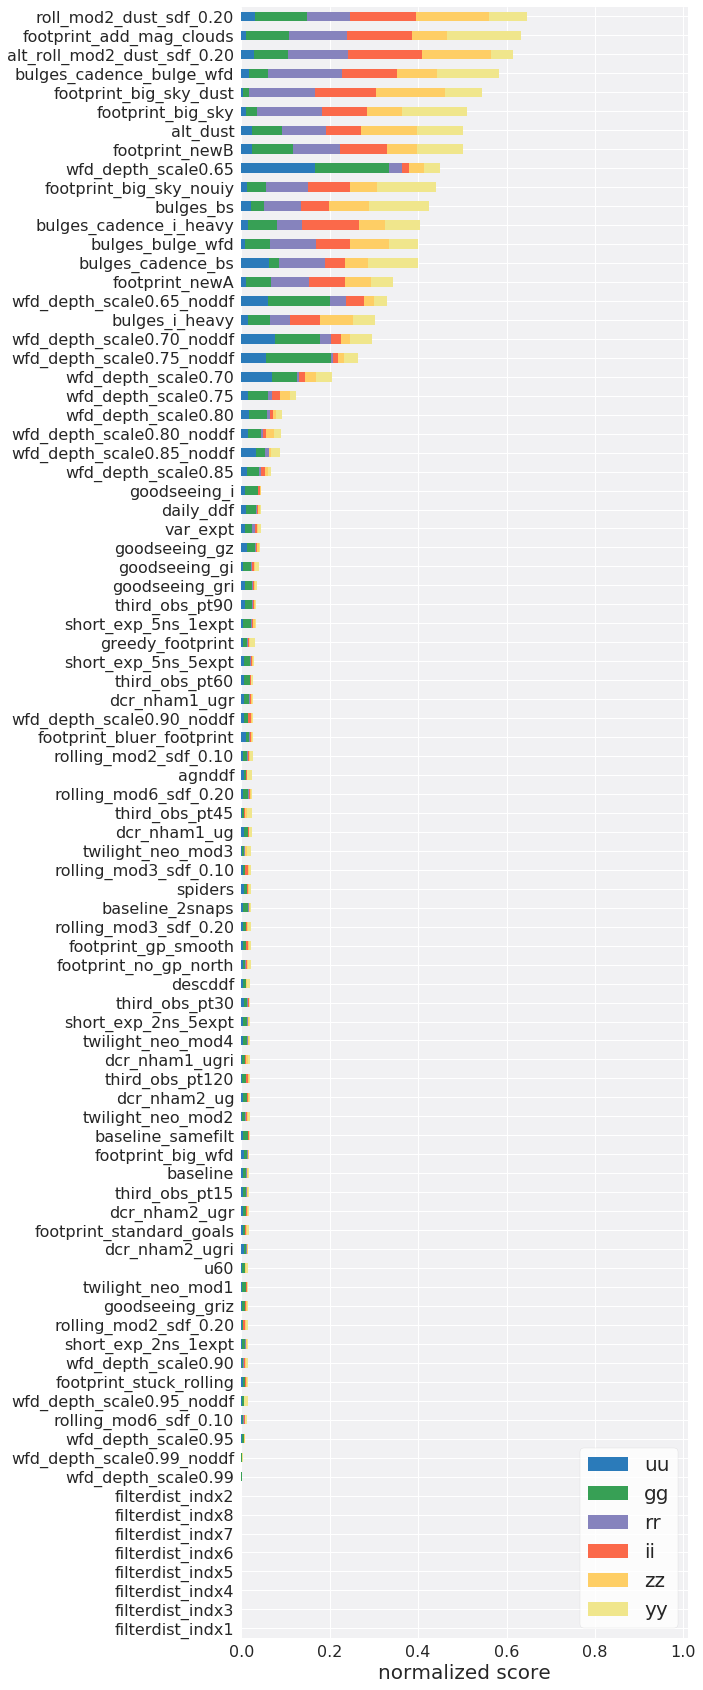

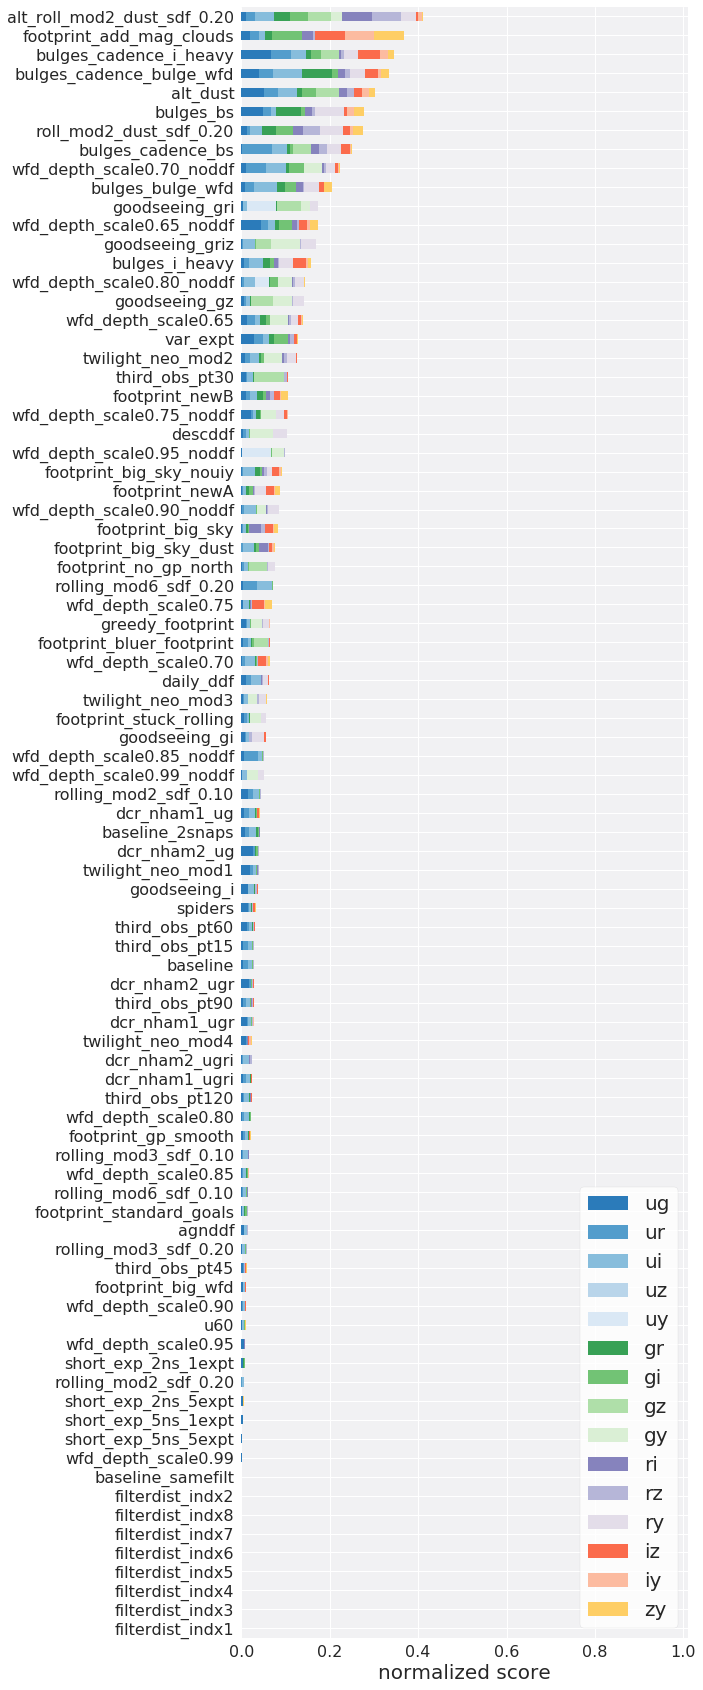

In [12]:
fomcsv = 'data/df_tgapsFoM_SMC.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_tgapsSMC_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_tgapSMC_diff.pdf', cmap=get_mycmap(pairs='diff') )



### Nfields GP

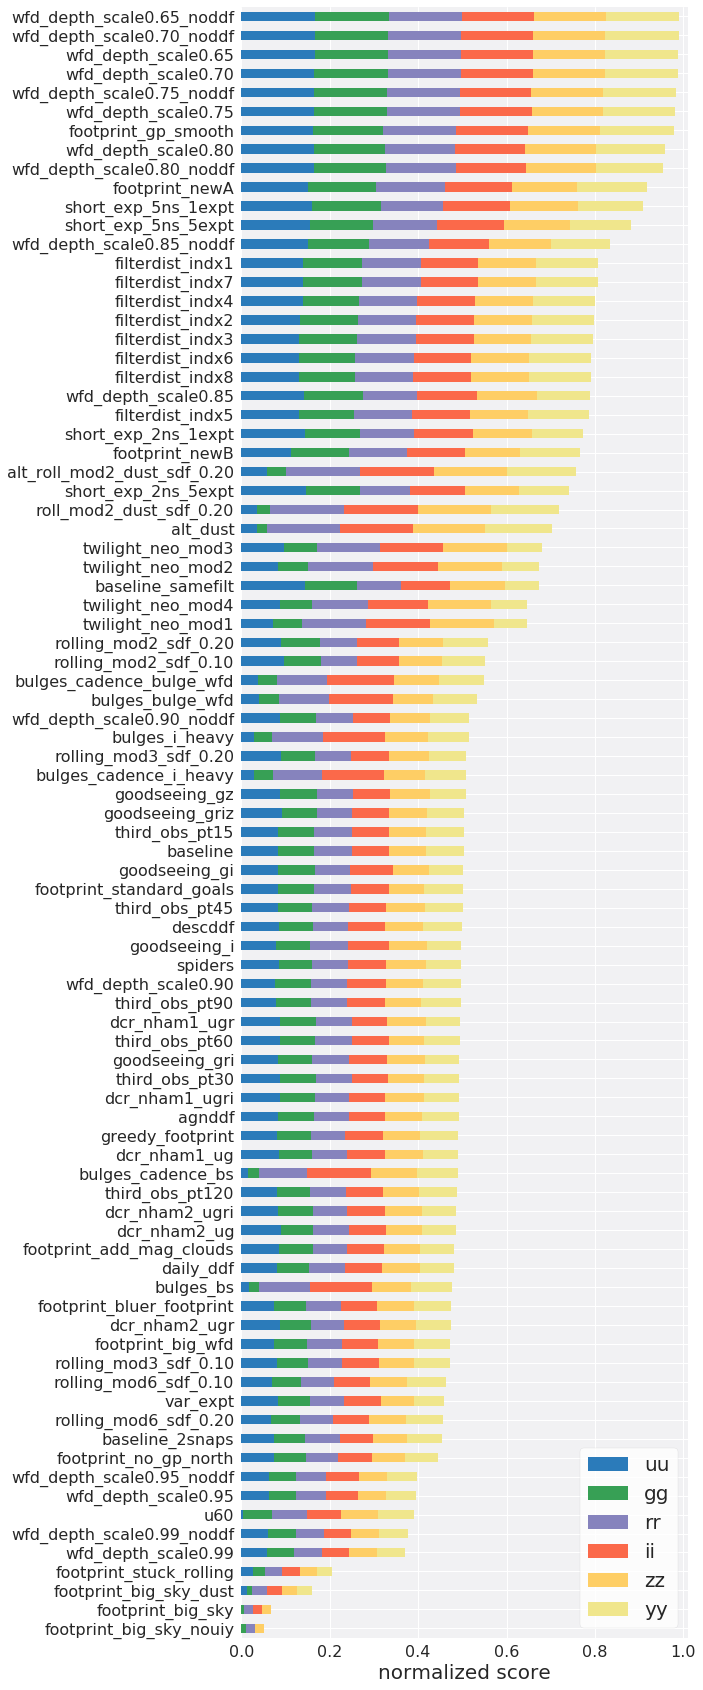

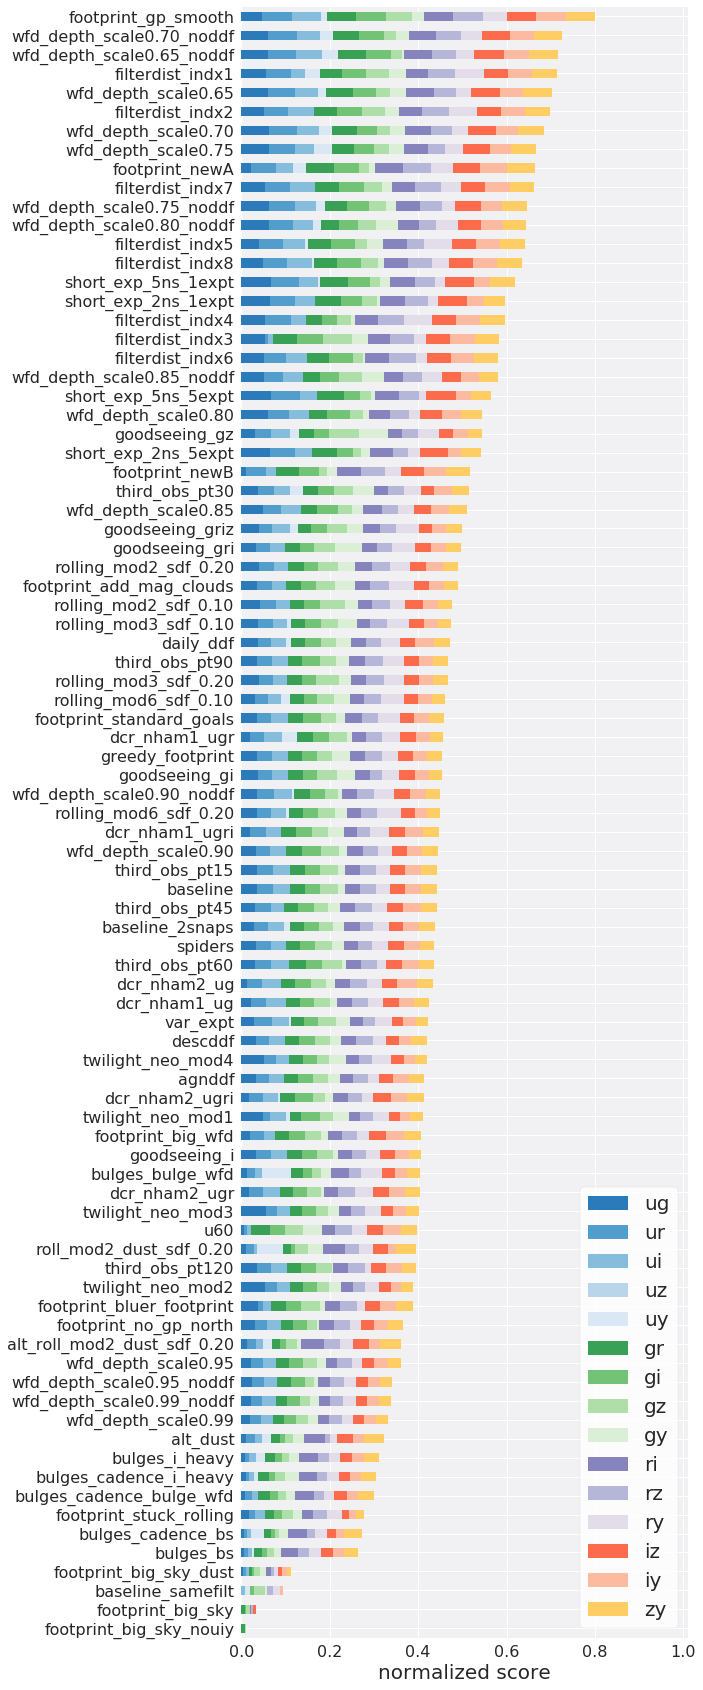

In [13]:
fomcsv = 'data/df_Nfields_GP.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_Nfields_GP_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_Nfields_GP_diff.pdf', cmap=get_mycmap(pairs='diff') )


### Nfields LMC

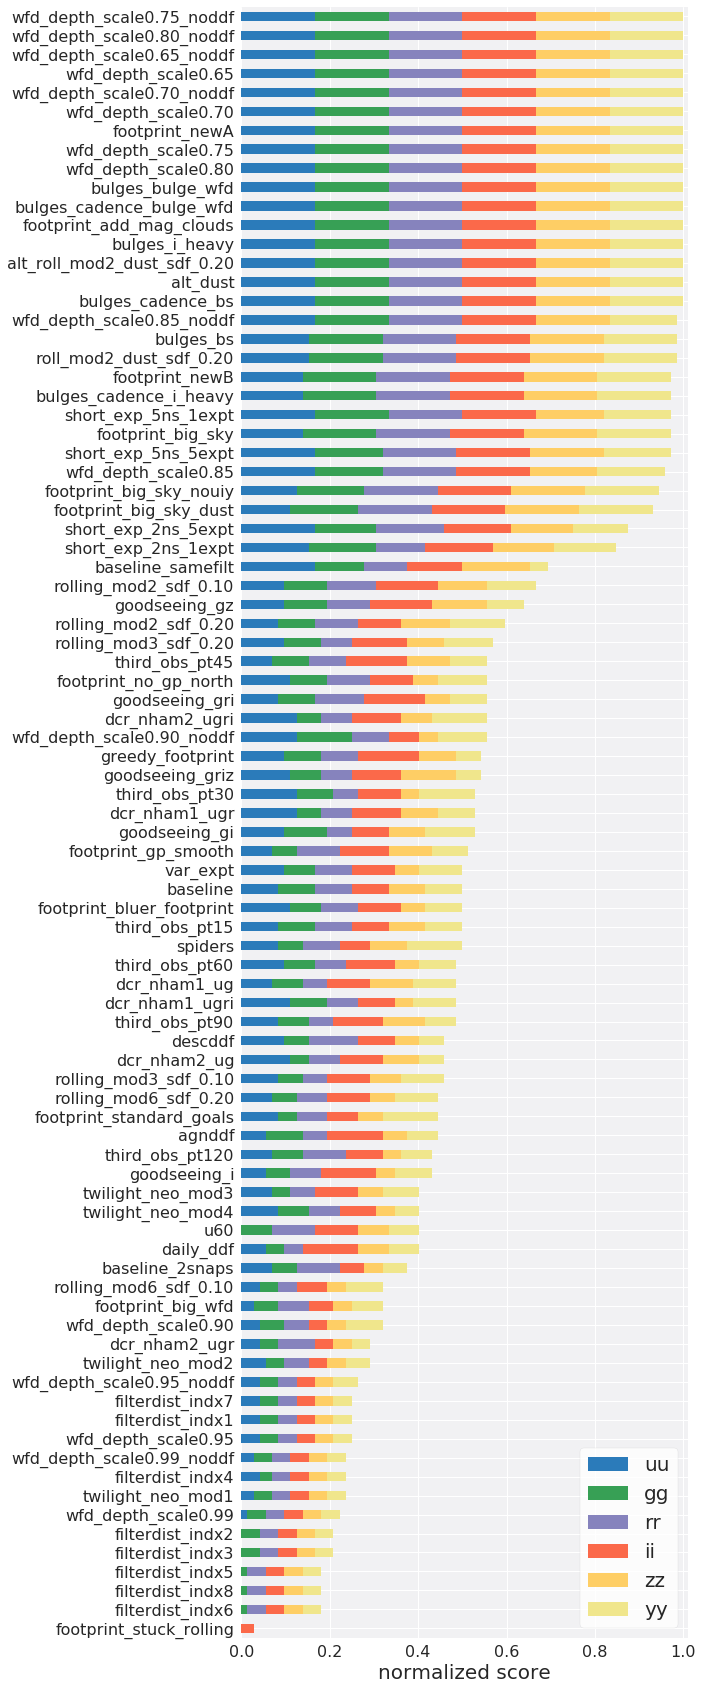

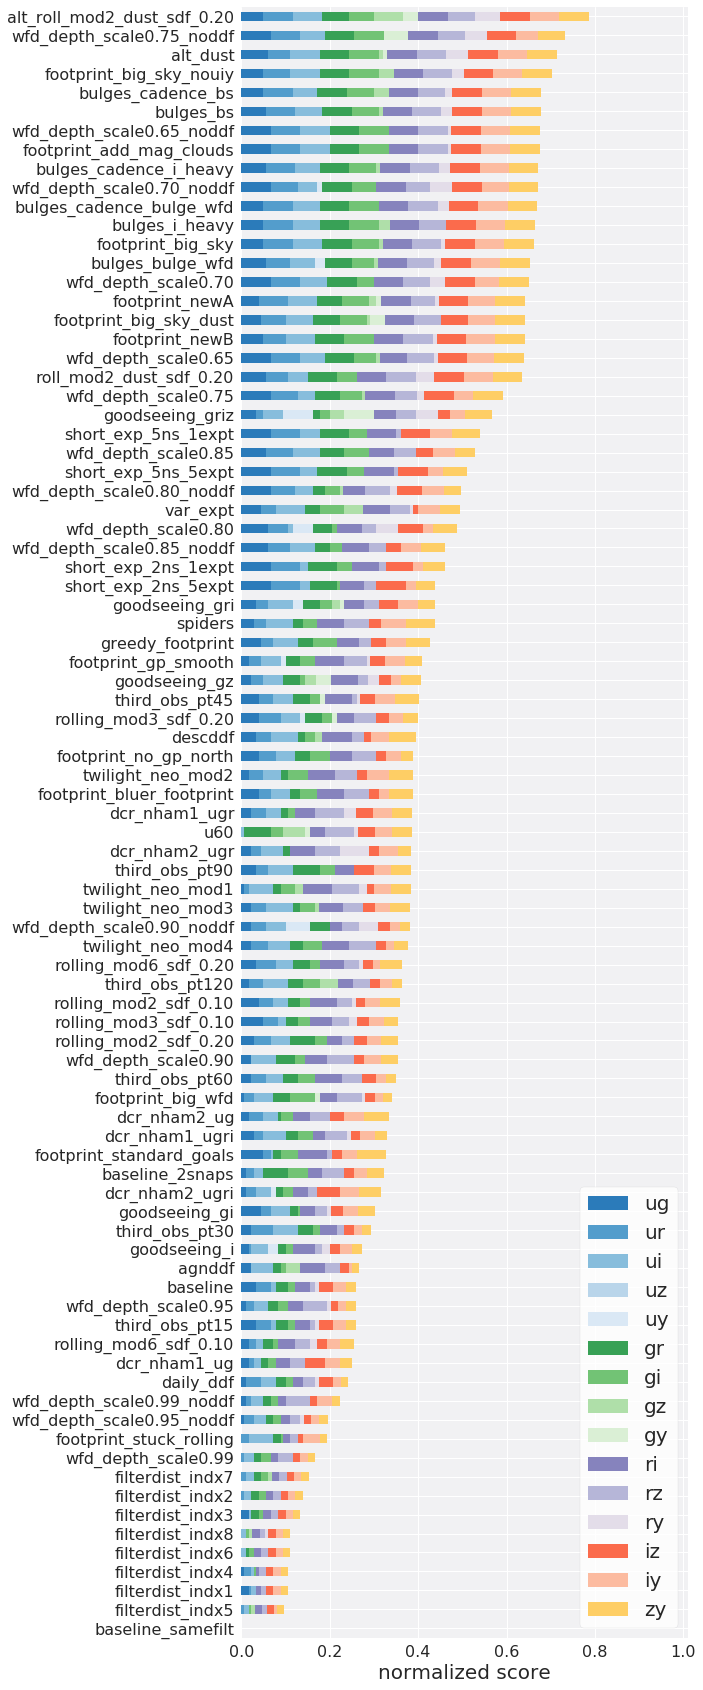

In [14]:
fomcsv = 'data/df_Nfields_LMC.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_Nfields_LMC_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_Nfields_LMC_diff.pdf', cmap=get_mycmap(pairs='diff') )


### Nfields SMC

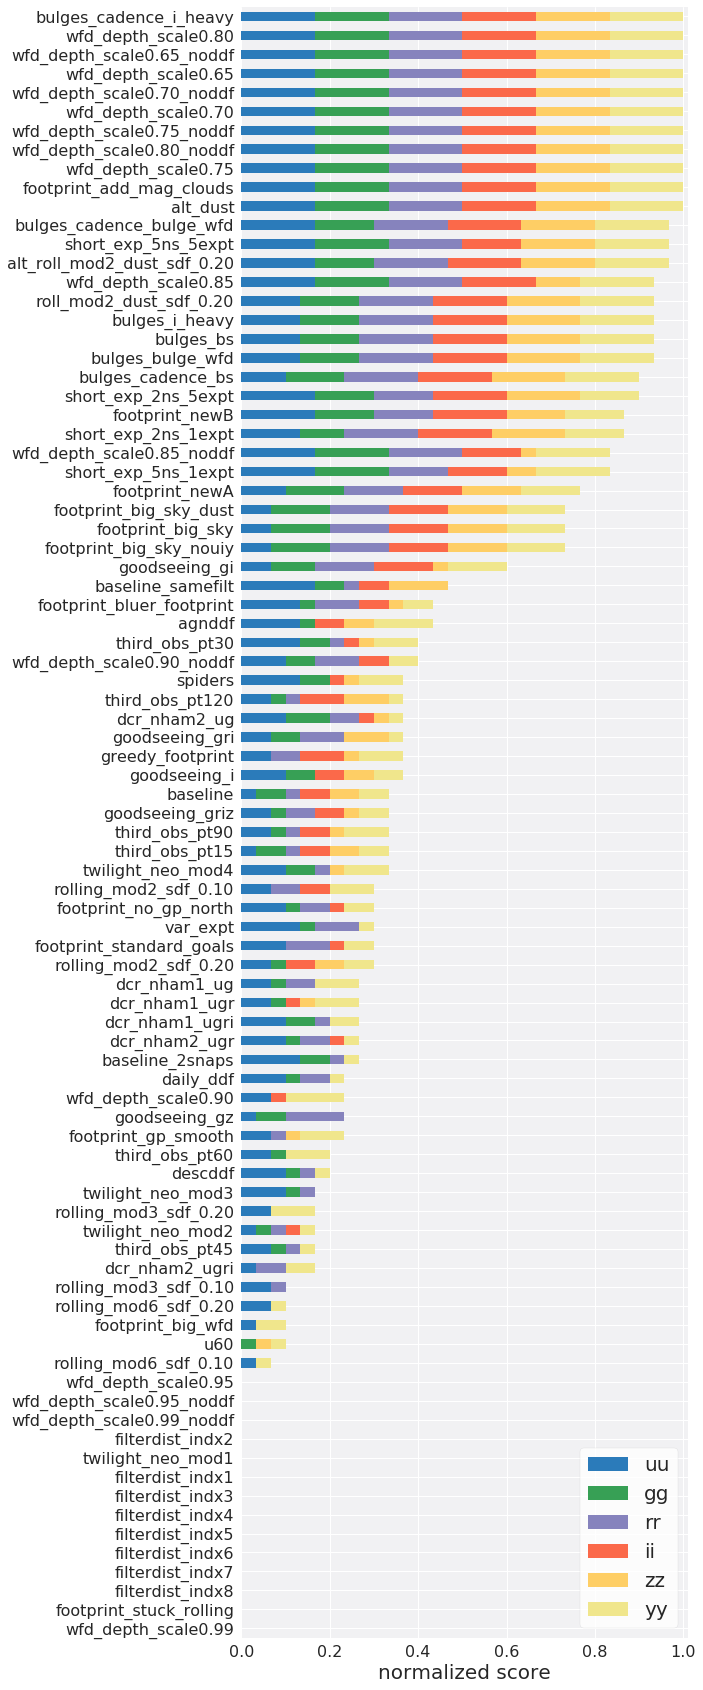

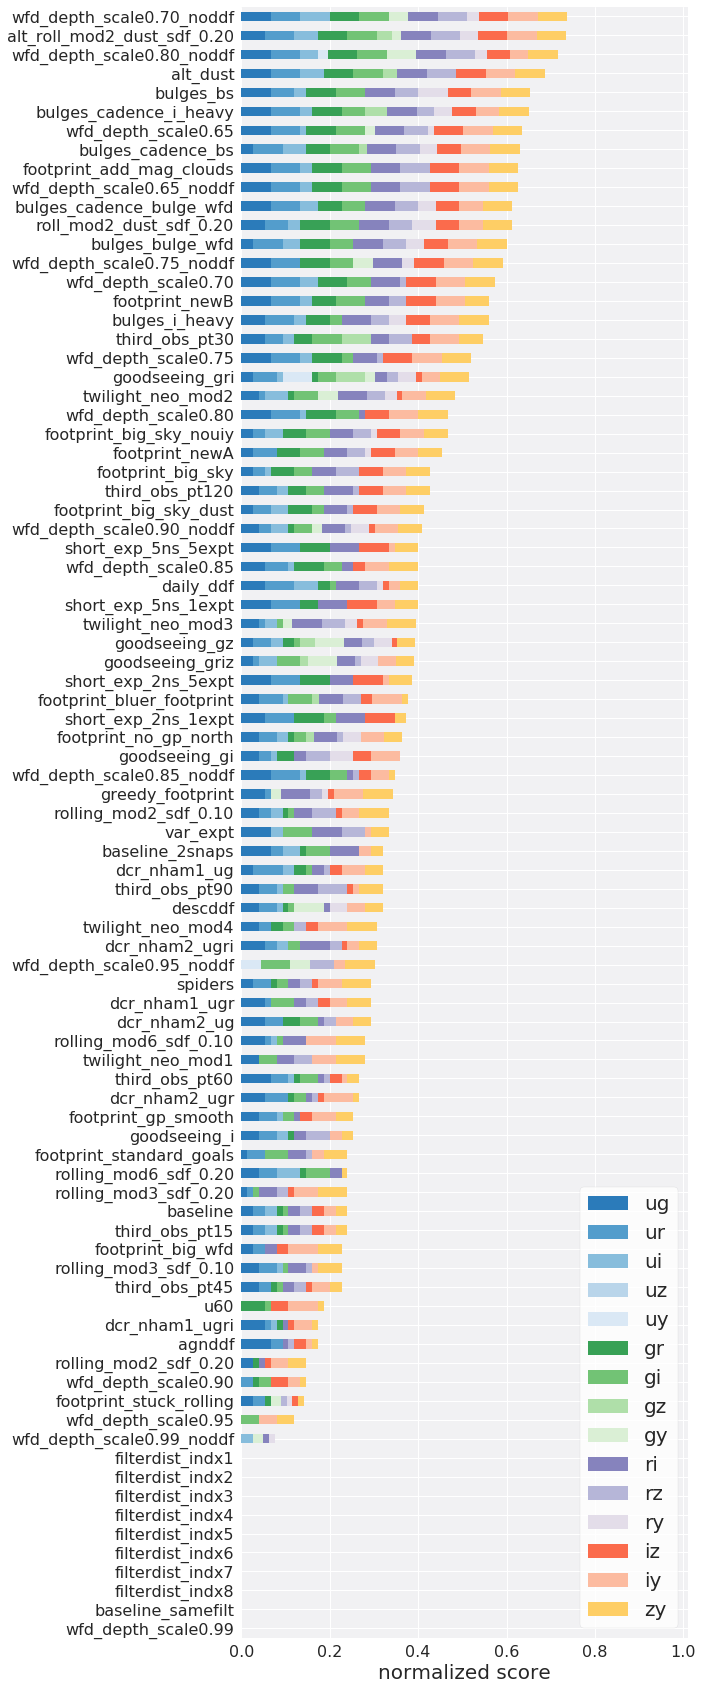

In [15]:
fomcsv = 'data/df_Nfields_SMC.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_Nfields_SMC_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_Nfields_SMC_diff.pdf', cmap=get_mycmap(pairs='diff') )



### Nstars GP

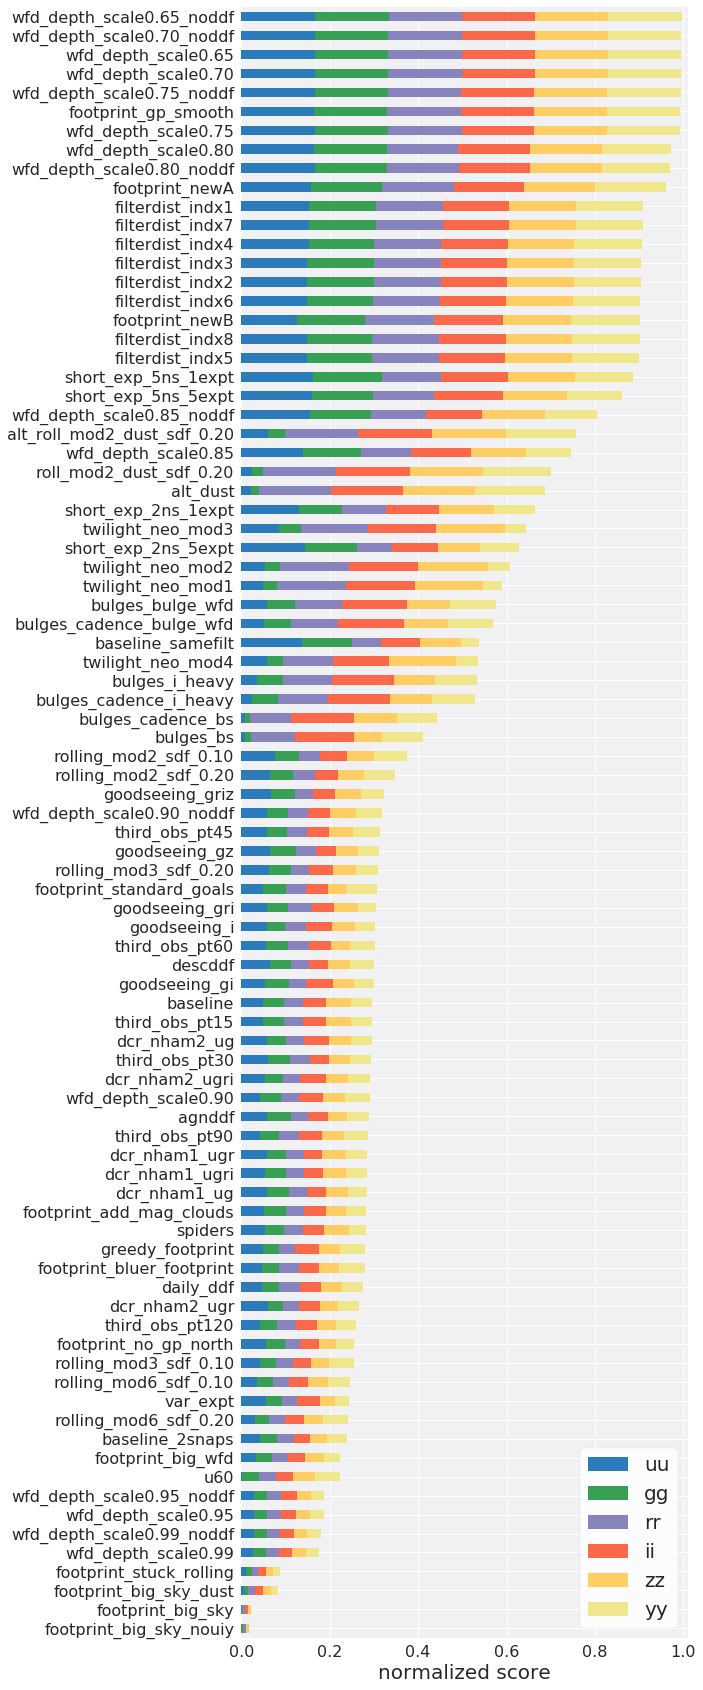

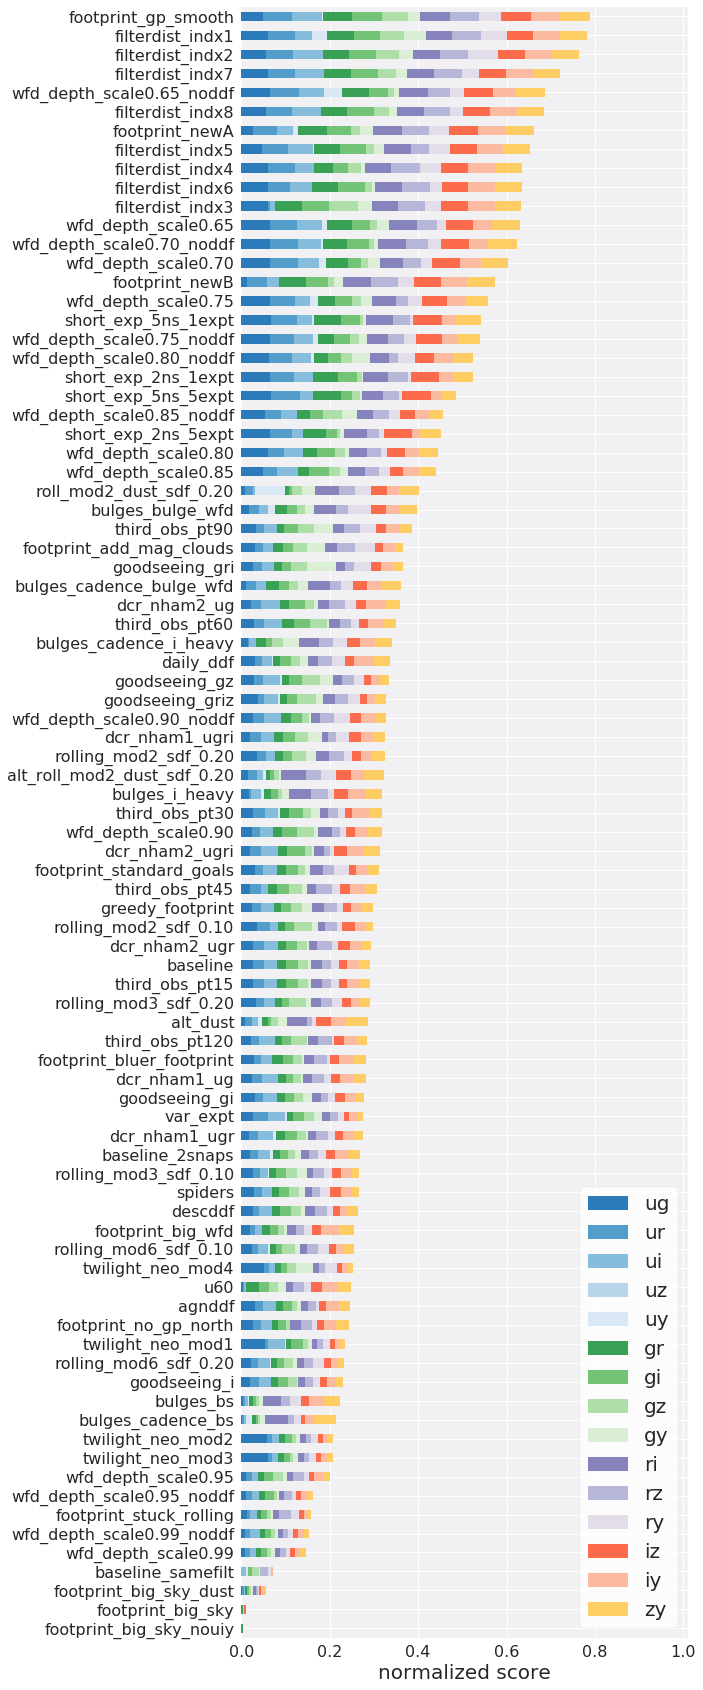

In [16]:
fomcsv = 'data/df_Nstar_GP.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_Nstars_GP_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_Nstarss_GP_diff.pdf', cmap=get_mycmap(pairs='diff') )



### Nstars LMC

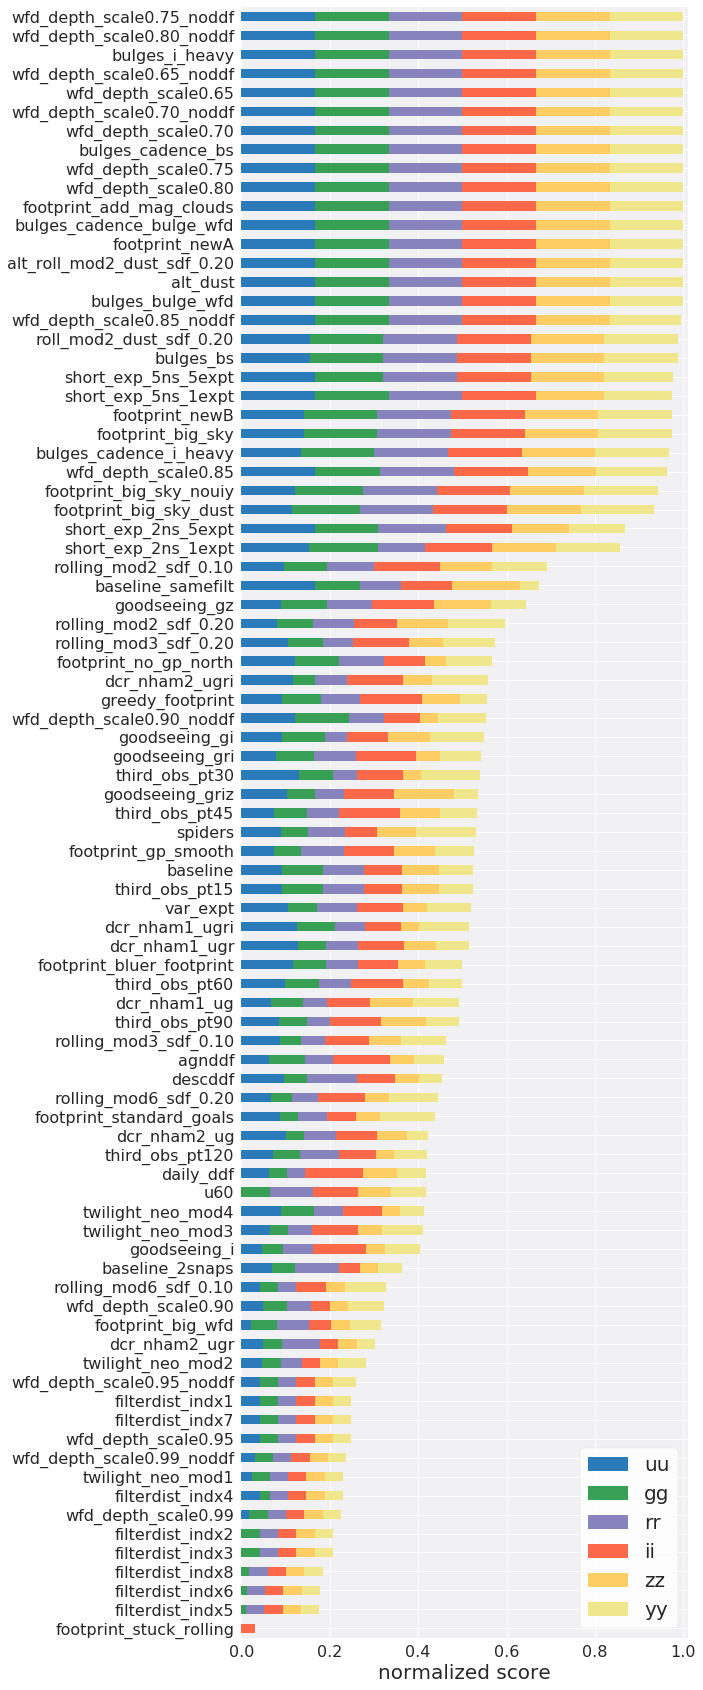

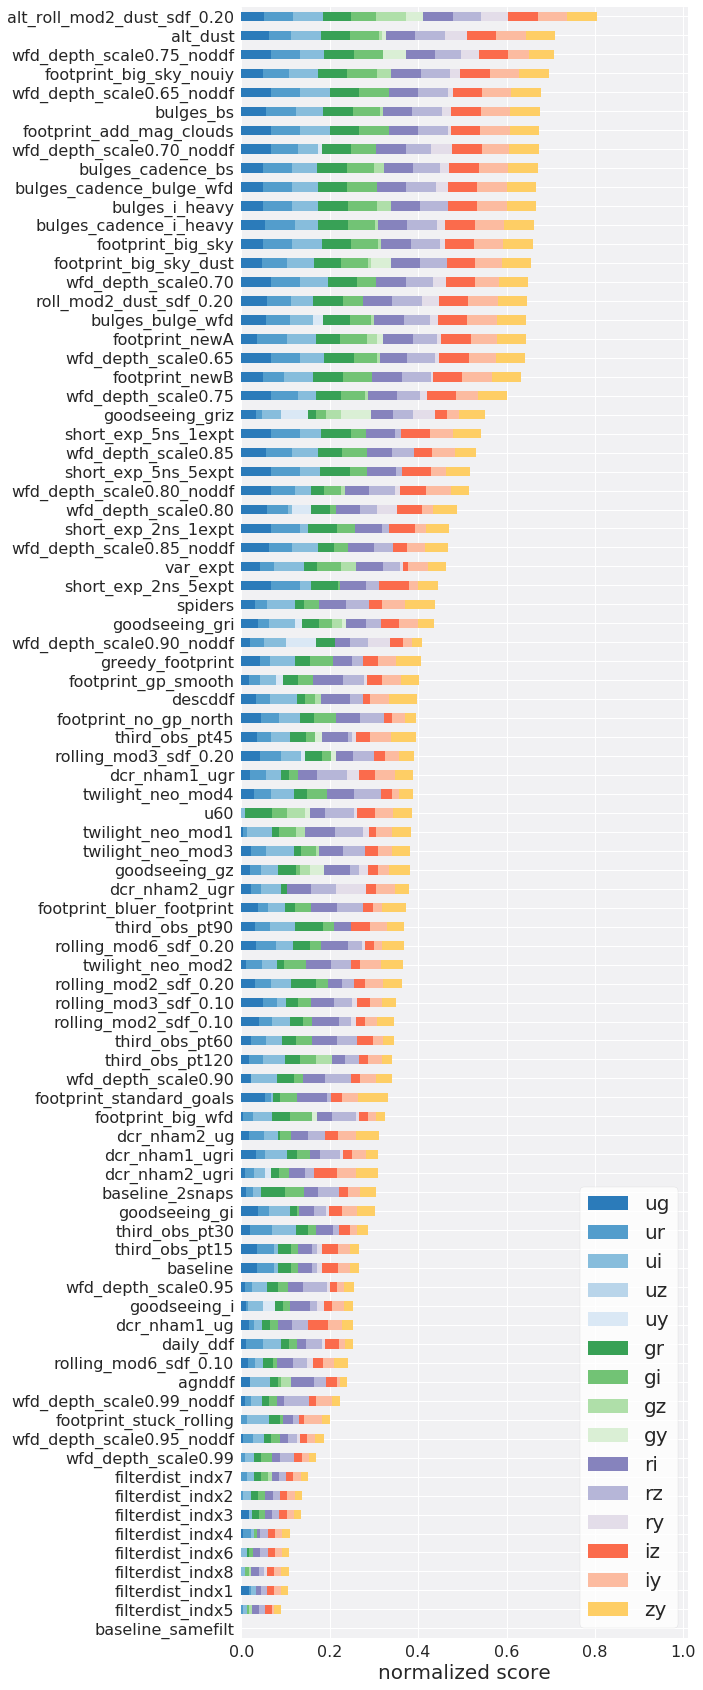

In [18]:
fomcsv = 'data/df_Nstar_LMC.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_Nstars_LMC_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_Nstarss_LMC_diff.pdf', cmap=get_mycmap(pairs='diff') )




### Nstars SMC

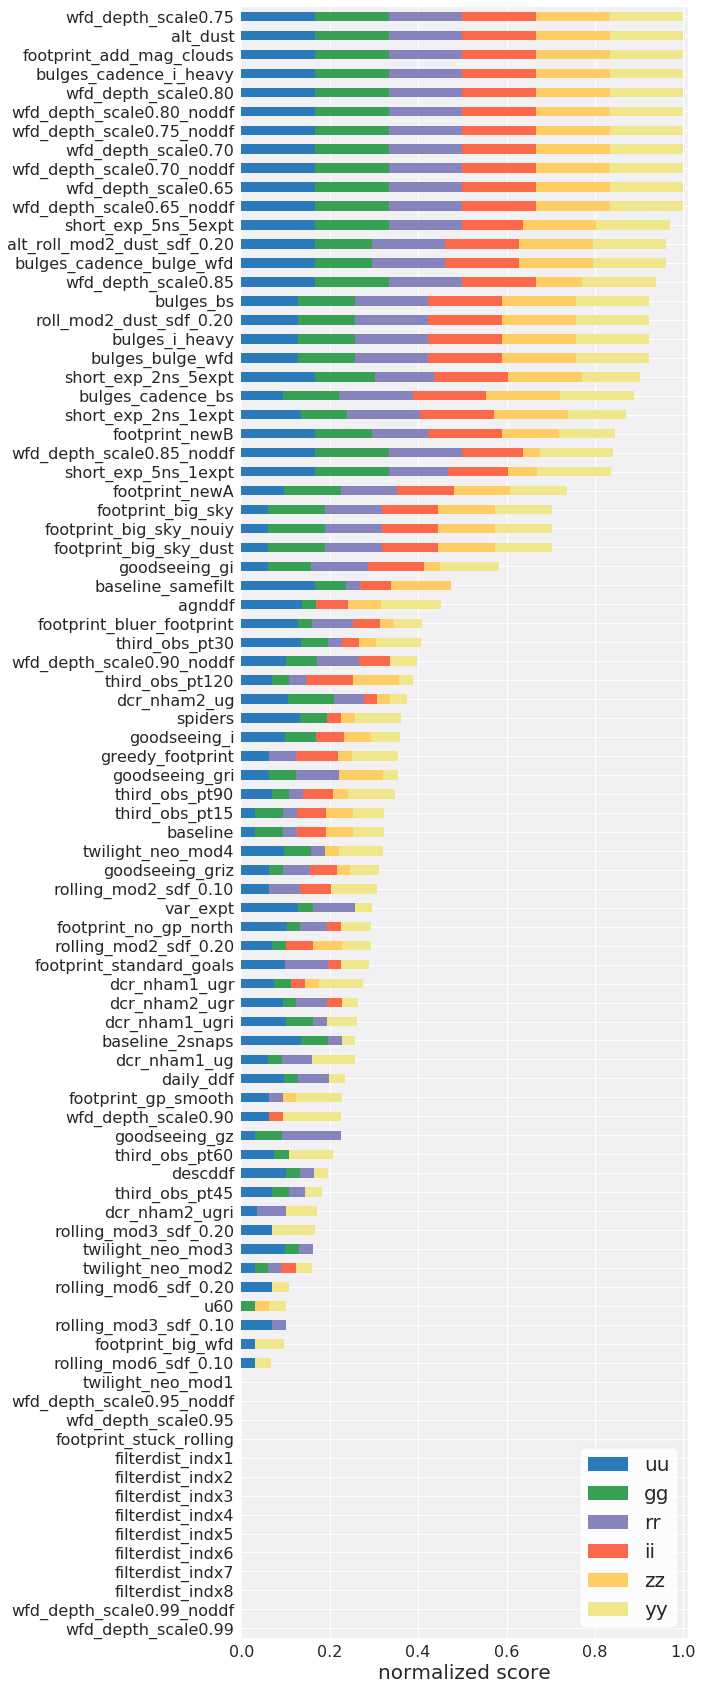

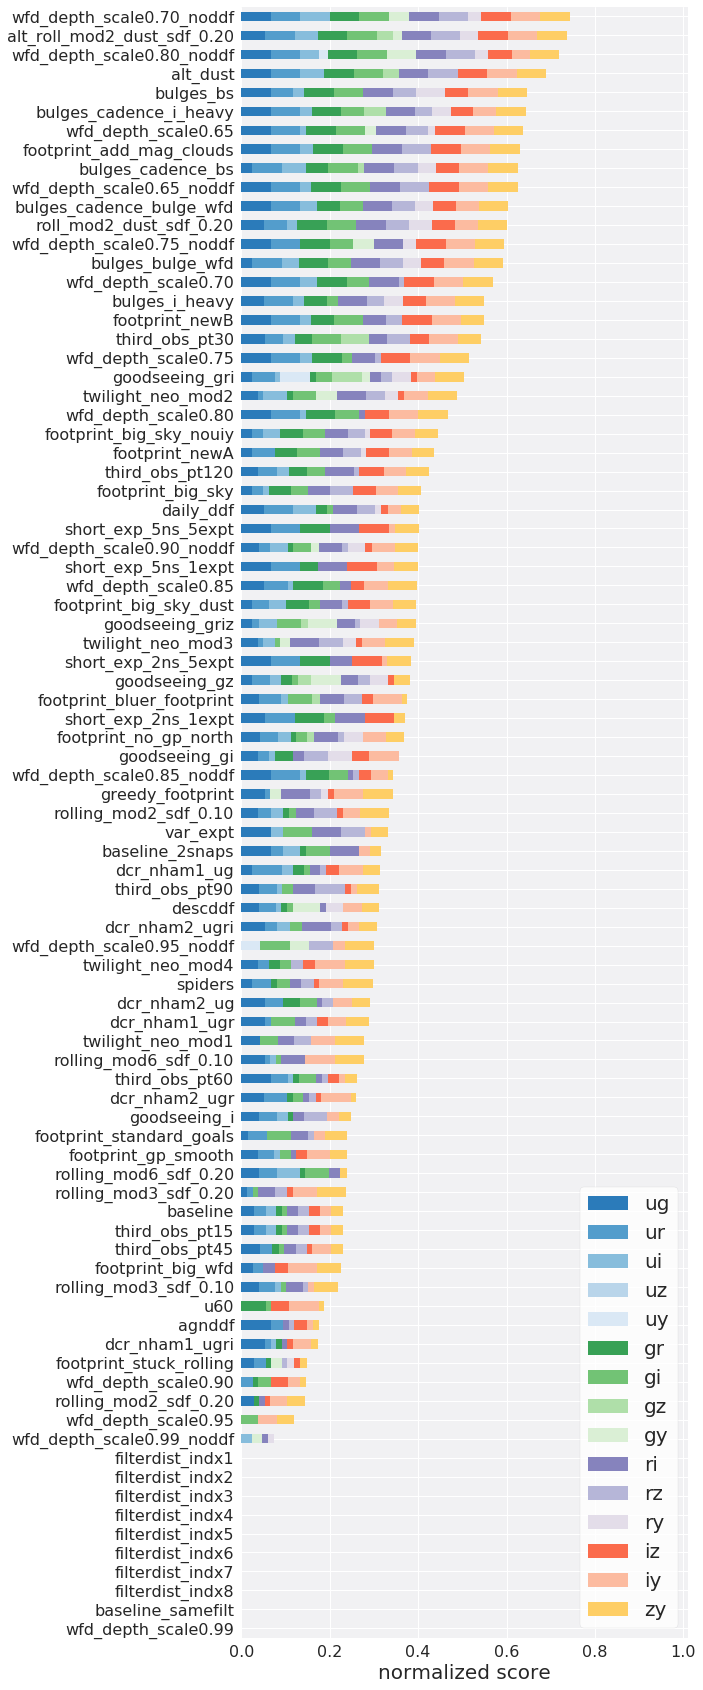

In [19]:
fomcsv = 'data/df_Nstar_SMC.csv'
df_norm = get_df_norm(fomcsv)
plot_barh(df_norm, cols_same, byfamily=False, savefig='figures/barh_Nstars_SMC_same.pdf', cmap=get_mycmap(pairs='same') )
plot_barh(df_norm, cols_diff, byfamily=False, savefig='figures/barh_Nstarss_SMC_diff.pdf', cmap=get_mycmap(pairs='diff') )

